In [10]:
import argparse
import configparser
import sys
import numpy as np
import random
import time
import os

import tensorflow as tf
from subprocess import check_output
import h5py
import re
import math
import pandas as pd
from os.path import splitext, basename, isfile
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn import mixture
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, BatchNormalization, Dropout, Activation, merge, Conv2D, \
    MaxPooling2D, Activation, LeakyReLU, concatenate, Embedding
from keras.models import Model, Sequential
from keras.losses import mse, binary_crossentropy
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects
from itertools import combinations
import bisect
from transformer import Attention,Position_Embedding
import matplotlib.pyplot as plt
from SADLN import SADLN,SADLN_API

In [39]:
parser = argparse.ArgumentParser(description='SADLN v1.0')       
parser.add_argument("-i", dest='file_input', default="./input/input.list", 
                    help="file input")
parser.add_argument("-e", dest='epochs', type=int, default=200, help="Number of iterations") #迭代次数
parser.add_argument("-m", dest='run_mode', default="feature", help="run_mode: feature, cluster") #运行模式
parser.add_argument("-w", dest='disc_weight', type=float, default=1e-4, help="weight")
parser.add_argument("-o", dest='output_path', default="./score/", help="file output")
parser.add_argument("-p", dest='other_approach', default="spectral", help="kmeans, spectral, tsne_gmm, tsne")
parser.add_argument("-s", dest='surv_path',
                    default="./data/TCGA/clinical_PANCAN_patient_with_followup.tsv",
                    help="surv input")
parser.add_argument("-t", dest='type', default="ALL", help="cancer type: BRCA, GBM")
parser.add_argument("-cn", dest='cluster_num', default=-1,  help="surv input")

args = parser.parse_args(["-m","SADLN","-t","BRCA","-i","./input/BRCA.list"])
args

Namespace(cluster_num=-1, disc_weight=0.0001, epochs=200, file_input='./input/BRCA.list', other_approach='spectral', output_path='./score/', run_mode='SADLN', surv_path='./data/TCGA/clinical_PANCAN_patient_with_followup.tsv', type='BRCA')

In [40]:
model_path = './model/' + args.type + '.h5'
SADLN = SADLN_API(model_path, epochs=args.epochs, weight=args.disc_weight, batch_size=64, learning_rate=0.0001)
cancer_dict = {'BRCA': 5, 'BLCA': 5, 'KIRC': 4,
                   'GBM': 3, 'LUAD': 3, 'PAAD': 2,
                   'SKCM': 4, 'STAD': 3, 'UCEC': 4, 'UVM': 4}

In [41]:
cancer_type = args.type
if cancer_type not in cancer_dict and args.cluster_num == -1:
    print("Please set the number of clusters!")
elif args.cluster_num == -1:
    args.cluster_num = cancer_dict[cancer_type]
fea_tmp_file = './fea/' + cancer_type + '.fea'
tmp_dir = './fea/' + cancer_type + '/'
if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)
ldata = []
l = []
nb_line = 0
for line in open(args.file_input, 'rt'):
    base_file = splitext(basename(line.rstrip()))[0]
    print(base_file)
    fea_save_file = tmp_dir + base_file + '.csv'
    if isfile(fea_save_file):
        df_new = pd.read_csv(fea_save_file, sep=',', header=0, index_col=0)
        l = list(df_new)
    df_new = df_new.T 
    ldata.append(df_new.values.astype(float))
ldata#Inpyut data

meth
rna
CN
miRNA


[array([[ 3.45780912, -0.1427983 ,  0.1886518 , ..., -0.47482471,
          0.07719969, -0.18278057],
        [ 2.06590635, -0.48137151, -0.49845869, ..., -0.60671451,
         -0.43145281, -0.56294201],
        [ 3.13715242, -0.12860091,  0.28624338, ..., -0.47492735,
          4.54087734, -0.35657181],
        ...,
        [-0.16177922, -0.05108415, -0.04188326, ..., -0.56747079,
          0.06331917, -0.34765533],
        [-0.07357891,  0.20129156,  0.47445398, ..., -0.40643018,
          0.76745586,  0.01564364],
        [ 1.95028055, -0.42011569, -0.22586772, ..., -0.86760271,
          2.24683042, -0.68975206]]),
 array([[-1.0699457 ,  0.25574757, -1.25376413, ...,  0.1308779 ,
          0.24341891,  0.91974324],
        [-1.0750015 , -0.87725047, -1.0750015 , ...,  0.75697465,
          1.66557759,  0.99823276],
        [-1.37704027,  1.62331694, -1.37704027, ..., -0.2474071 ,
          0.57736352,  0.48856707],
        ...,
        [-1.33981452, -0.70831681, -1.33981452, ..., -

In [42]:
#model
vec = SADLN.feature_gan(ldata, index=l, n_components=100,
                             bTrain= True,
                             weight=args.disc_weight)
vec.to_csv(fea_tmp_file, header=True, index=True, sep='\t')
vec.head()#feature

1031
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 3139)         0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, 3217)         0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 3105)         0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           (None, 383)          0                                            
__________________________________________________________________________________________________
dense

Epoch: 0 d_loss: [0.7825693 0.5      ] g_loss: [1.0609316, 1.026576, 1.0292509, 1.0268588, 1.1611184, 0.86612934]
Epoch: 10 d_loss: [0.77455646 0.5234375 ] g_loss: [1.0346293, 1.0078195, 0.9910345, 1.014365, 1.1253686, 0.8600198]
Epoch: 20 d_loss: [0.74524415 0.4765625 ] g_loss: [0.99537677, 0.9822969, 0.93907267, 0.99599457, 1.0641971, 0.8598025]
Epoch: 30 d_loss: [0.75744283 0.53125   ] g_loss: [0.95463055, 0.9531335, 0.8804715, 0.980129, 1.0048413, 0.8220562]
Epoch: 40 d_loss: [0.75972426 0.546875  ] g_loss: [0.9111617, 0.92764616, 0.82383573, 0.95957977, 0.93362033, 0.8238635]
Epoch: 50 d_loss: [0.7502598 0.5078125] g_loss: [0.8765641, 0.90575504, 0.77603537, 0.9493246, 0.87515634, 0.83951366]
Epoch: 60 d_loss: [0.72742516 0.5       ] g_loss: [0.8405765, 0.8876878, 0.7245318, 0.93237746, 0.8177196, 0.8142642]
Epoch: 70 d_loss: [0.7213353 0.5546875] g_loss: [0.8017648, 0.8601603, 0.6724857, 0.9154764, 0.7589427, 0.78699946]
Epoch: 80 d_loss: [0.7130052 0.5703125] g_loss: [0.7686645,

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99
TCGA-D8-A1XJ,9.529078,6.730706,-0.762055,-4.193951,4.002219,0.593093,0.372004,-4.695280,0.386950,-1.669967,...,1.484645,-0.887764,2.056836,-0.388203,-3.127971,2.442243,-1.533731,-5.677299,6.903499,-1.403896
TCGA-EW-A6SA,0.787608,2.417957,-2.471471,-3.269685,-3.598834,7.051179,5.143160,-0.171343,-8.173271,-1.241626,...,-6.592796,0.090884,0.115012,8.728924,4.820042,1.181957,-7.213793,-2.533416,-1.958098,-5.538571
TCGA-D8-A27H,10.891781,5.247213,0.365170,-3.778866,1.866479,0.931364,-0.617874,-6.006254,0.941964,-2.125788,...,0.876757,0.570029,0.091529,0.362842,-2.613082,1.014948,-1.428882,-6.941031,6.848411,-2.246806
TCGA-E9-A247,1.424010,2.975856,-2.931728,-3.936788,-3.267493,6.884218,5.275084,-0.512483,-8.690865,-1.240714,...,-6.402796,-0.379067,0.798559,8.839704,4.284833,1.635859,-7.356526,-2.398023,-2.198218,-6.207304
TCGA-AC-A2FG,1.912644,0.842904,-1.927490,0.104523,-8.511543,7.764237,1.562774,-3.472150,-8.125443,-2.637433,...,-9.244042,3.197149,-3.162980,10.205389,5.801705,-0.073635,-8.029344,-2.280002,-4.284722,-9.640231


In [43]:
# gmm
if isfile(fea_tmp_file):
    X = pd.read_csv(fea_tmp_file, header=0, index_col=0, sep='\t')
    X['SADLN'] = SADLN.gmm(args.cluster_num).fit_predict(X.values) + 1
    X = X.loc[:, ['SADLN']] # (col, 1)
    out_file = './results/' + cancer_type + '.SADLN'
    X.to_csv(out_file, header=True, index=True, sep='\t')
else:
    print('file does not exist!')
X.head()#clustering results

,SADLN
TCGA-D8-A1XJ,4
TCGA-EW-A6SA,1
TCGA-D8-A27H,2
TCGA-E9-A247,1
TCGA-AC-A2FG,5


D:\Anaconda\envs\tf_py3.7\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Anaconda\envs\tf_py3.7\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1031, 2)


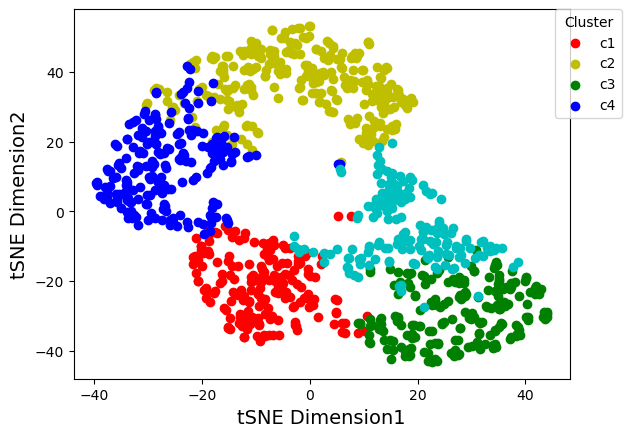

In [44]:
#Visualization
cancer_type = args.type
fea_tmp_file = './fea/' + cancer_type + '.fea'
out_file = './fea/' + cancer_type + '.tsne'
label_file = './results/' + cancer_type + '.SADLN'
if isfile(fea_tmp_file):
    df1 = pd.read_csv(fea_tmp_file, header=0, index_col=0, sep='\t')
    mat = df1.values.astype(float)
    labels = SADLN.tsne(mat)
    print(labels.shape)
    df1['x'] = labels[:, 0]
    df1['y'] = labels[:, 1]
    df1 = df1.loc[:, ['x', 'y']]
    df1.to_csv(out_file, header=True, index=True, sep='\t')
    if isfile(label_file):
        df2 = pd.read_csv(label_file, header=0, index_col=0, sep='\t')
        df1 = pd.merge(df1,df2,left_index=True,right_index=True)
        d = df1[df1.SADLN == 1]
        plt.scatter(d.values[:,0], d.values[:,1], c='r', label='c1')

        d = df1[df1.SADLN == 2]
        plt.scatter(d.values[:,0], d.values[:,1], c='y', label='c2')

        d = df1[df1.SADLN == 3]
        plt.scatter(d.values[:,0], d.values[:,1], c='g', label='c3')

        d = df1[df1.SADLN == 4]
        plt.scatter(d.values[:,0], d.values[:,1], c='b', label='c4')

        d = df1[df1.SADLN == 5]
        plt.scatter(d.values[:,0], d.values[:,1], c='c', label='c5')
        plt.xlabel("tSNE Dimension1", fontsize=14)
        plt.ylabel("tSNE Dimension2", fontsize=14)
        plt.legend(['c1', 'c2','c3','c4'],title="Cluster",loc=1, bbox_to_anchor=(1.105,1.0),borderaxespad = 0.)
        plt.show()
else:
            print('file does not exist!')